In [1]:
import numpy as np
import pandas as pd
import plotly.express as px 
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [31]:
import dash
from dash import Dash, dcc, html, Input, Output, dash_table
import dash_bootstrap_components as dbc
import dash.dependencies as dd

In [3]:
import base64
from io import BytesIO

# GET DATA

In [4]:
granules_summary_url = 'https://raw.githubusercontent.com/yixiq97/API_data/main/CREC_granules_summary.csv'
granules_summary_df = pd.read_csv(granules_summary_url) #,index_col=0,parse_dates=[0])

summary_url = 'https://raw.githubusercontent.com/yixiq97/API_data/main/CREC_summary.csv'
summary_df = pd.read_csv(summary_url) #,index_col=0,parse_dates=[0])

In [5]:
granules_info_add = pd.read_csv('granules_info_add.csv', header=0)

In [6]:
tf_mtx = np.loadtxt('tf_matrix.txt', dtype=np.float64)
tfidf_mtx = np.loadtxt('tfidf_matrix.txt', dtype=np.float64)

topic_word_distributions =  np.loadtxt('topic_word_distributions.txt', dtype=np.float64)
topic_doc_proportions =  np.loadtxt('topic_doc_proportions.txt', dtype=np.float64)

In [7]:
vocabs = np.genfromtxt('vocabs.txt',dtype=str,delimiter="\n")

In [78]:
num_pages_df = summary_df.groupby('dateIssued').agg({'pages': np.sum})
num_granules_df = granules_summary_df.groupby('dateIssued').agg({'granulesCount': np.sum})

num_pages_df = num_pages_df.reset_index()
num_granules_df = num_granules_df.reset_index()

num_pages_df = num_pages_df.iloc[num_pages_df.index[num_pages_df['dateIssued'] == summary_df['dateIssued'][len(summary_df)-1]][0]:]
num_granules_df = num_granules_df.iloc[num_pages_df.index[num_pages_df['dateIssued'] == summary_df['dateIssued'][len(summary_df)-1]][0]:]

# GENERATE VISUALIZATION

## Histograms: topics, topis-words, topic-docs

In [20]:
# histogram: granule number of each topic
most_probable_topic = np.argmax(topic_doc_proportions, axis=1)
most_probable_topic_str = ['Topic '+ str(i) for i in most_probable_topic]
def get_topics_hist(most_probable_topic):
    topics_hist = []
    for i in np.unique(most_probable_topic):
        topics_hist.append(('Topic '+ str(i),len(np.where(most_probable_topic == i)[0])))
    return topics_hist

In [10]:
# histogram: top words of each topic
def get_topic_words_hist(topic_word_distributions,vocabs,num_top_words = 20):
    num_topics = len(topic_word_distributions)
    topic_words = []
    for topic_idx in range(num_topics):
        topic_i_words = []
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            topic_i_words.append([vocabs[word_idx],round(topic_word_distributions[topic_idx, word_idx],4)])
        topic_words.append(topic_i_words)
    return topic_words

In [11]:
# histogram: top documents of each topic
docs_titles = granules_info_add['title'].to_list()
def get_topic_docs_hist(topic_doc_proportions,topics_hist,docs_titles,num_top_docs = 10):
    num_topics = topic_doc_proportions.shape[1]
    topic_docs = []
    for topic_idx in range(num_topics):
        topic_i_docs = []
        sort_indices = np.argsort(-topic_doc_proportions[:,topic_idx])
        if num_top_docs> topics_hist[topic_idx][1]:
            for rank in range(topics_hist[topic_idx][1]):
                doc_idx = sort_indices[rank]
                topic_i_docs.append((docs_titles[doc_idx],round(topic_doc_proportions[doc_idx,topic_idx],4)))
        else:
            for rank in range(num_top_docs):
                doc_idx = sort_indices[rank]
                topic_i_docs.append((docs_titles[doc_idx],round(topic_doc_proportions[doc_idx,topic_idx],4)))
        topic_docs.append(topic_i_docs)    
    return topic_docs

### Get values for histograms and docs_table

In [12]:
def get_hist(hist_ls):
    names = [i[0] for i in hist_ls]
    numbers = [i[1] for i in hist_ls]
    return names,numbers

def get_topic_hist(topic_hist_ls,topic_idx):
    topics = ['Topic '+ str(i) for i in range(len(topic_hist_ls))]
    topic = topics[topic_idx]
    names_topic,numbers_topic = get_hist(topic_hist_ls[topic_idx])
    return topic,names_topic,numbers_topic

In [13]:
topics_hist = get_topics_hist(most_probable_topic)
#topic_words_hist = get_topic_words_hist(topic_word_distributions,vocabs)
topic_docs_hist = get_topic_docs_hist(topic_doc_proportions,topics_hist,docs_titles)

In [14]:
topic_docs_ls = []
for t in range(len(topic_docs_hist)):
    ls = ['']*len(topic_docs_hist)
    for i in range(len(topic_docs_hist[t])):
        ls[i] = topic_docs_hist[t][i][0]
    topic_docs_ls.append(ls)
topic_docs_ls

topic_docs_table = pd.DataFrame(topic_docs_ls).transpose()
topic_docs_table.columns = ['Topic '+ str(i) for i in range(len(topic_docs_ls))]
topic_docs_table

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,"Explanatory Statement Submitted By Mr. Leahy, ...",Text Of Senate Amendment 6525,Nominations,Text Of Amendments,Explanatory Material Statement Submitted By Mr...,James M. Inhofe National Defense Authorization...,The Psychology Of Consensus,Executive And Other Communications,Text Of Senate Amendment 6552,Constitutional Authority And Single Subject St...
1,"Explanatory Statement Submitted By Mr. Leahy, ...",Text Of Senate Amendment 6589,Amendments Submitted And Proposed,House Of Representatives,Tribute To Senior Master Sergeant Ryan E. Byrne,Arms Sales Notification,This Christmas Season Hardworking American Tax...,Executive And Other Communications,"Agriculture, Rural Development, Food And Drug ...",Constitutional Authority And Single Subject St...
2,"Explanatory Statement Submitted By Mr. Leahy, ...",Text Of Senate Amendment 6568,Amendments Submitted And Proposed,Senate,Introductory Statement On S. 5185,Text Of Senate Amendment 6510,Kids Online Safety Act (Executive Session),Executive And Other Communications,Text Of Amendments,Text Of Senate Amendment 6547
3,Congratulating Midlands Technical College Stud...,Statements On Introduced Bills And Joint Resol...,Reports Of Committees,Senate,Statements On Introduced Bills And Joint Resol...,Arms Sales Notification,Announcement By The Clerk,Executive And Other Communications,Text Of Senate Amendment 5044,Constitutional Authority And Single Subject St...
4,Lake Champlain,Text Of Senate Amendment 6505,Measures Referred,Daily Digest/Senate,Confirmations,Arms Sales Notification,Democratic Caucus (Executive Session),"Executive Communications, Etc.",Text Of Senate Amendment 6551,Hualapai Tribe Water Rights Settlement Act Of ...
5,Internal Revenue Service (Executive Session),Text Of Amendments,Reports Of Committees,House Of Representatives,National Defense Authorization Act (Executive ...,Text Of Senate Amendment 6485,Saving Lives,Authority For Committees To Meet,Text Of Senate Amendment 5043,Constitutional Authority Statement For H.R. 9612
6,National Defense Authorization Act,Text Of Senate Amendment 6506,Measures Referred,,Honoring The Life And Service Of Captain Thoma...,Text Of Senate Amendment 6523,Opposing Extreme Anti-Abortion Agenda,Authority For Committees To Meet,Text Of Amendments,Constitutional Authority Statement For H.R. 9497
7,Submitted Resolutions,Text Of Senate Amendment 6513,Confirmations,,Confirmation,Civilian Cyber Security Reserve Act,Securing Our Border,Authority For Committees To Meet,Commitment To Veteran Support And Outreach Act,Constitutional Authority Statement For H.R. 9595
8,Tribute To Dr. Patrick Breysse,Text Of Senate Amendment 6558,Executive Reports Of Committees,,Tribute To Lieutenant Colonel Jeffrey ``Slande...,Arms Sales Notification,Recognizing Larry'S Mini Mart,Authority For Committees To Meet,Text Of Senate Amendment 6565,Constitutional Authority Statement For H.R. 185
9,Supporting The Omnibus Appropriations And Cons...,Text Of Senate Amendment 6556,Reports Of Committees,,Tribute To James M. Inhofe (Executive Calendar),Morning Business,Commemorating Korean American Day,Executive Session,Text Of Senate Amendment 6564,Constitutional Authority And Single Subject St...


## t-SNE Visualization

In [15]:
topic_tsne_lda_80 = np.loadtxt('topic_lda_tsne_perplexity80.txt', dtype=np.float64)
topic_tsne_lda_80 # x: topic_tsne_lda[most_probable_topic==t,0], y: topic_tsne_lda[most_probable_topic==t,1]

array([[ -8.629867, -17.226377],
       [-35.696568, -17.425606],
       [-25.625528, -18.197657],
       ...,
       [  6.185665, -14.514004],
       [-12.778729, -18.340797],
       [-25.628574, -18.199665]])

In [18]:
tsne_data = pd.DataFrame()
tsne_data['1st Component'] = topic_tsne_lda_80[:,0]
tsne_data['2nd Component'] = topic_tsne_lda_80[:,1]
tsne_data['Topic'] = most_probable_topic_str
tsne_data['Date issued'] = granules_info_add['dateIssued']
tsne_data['Granule title'] = granules_info_add['title']

In [21]:
tsne_fig = px.scatter(tsne_data, x='1st Component', y='2nd Component',
                     color='Topic', 
                     hover_data=['Date issued','Granule title'],
                     category_orders={'Topic':['Topic '+ str(i) for i in range(topic_doc_proportions.shape[1])]},
                     color_discrete_sequence=px.colors.qualitative.D3,
                     )
tsne_fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
tsne_fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='rgba(242,242,242,242)')#rgba(204,204,204,204)
tsne_fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='rgba(242,242,242,242)')
tsne_fig

## PCA Visualization

In [22]:
topic_pca_lda = np.loadtxt('topic_lda_pca.txt', dtype=np.float64)
topic_pca_lda # x: topic_pca_lda[:,0], y: topic_pca_lda[:,1];color =most_probable_topic

array([[-0.28262468, -0.00201447],
       [-0.57787265, -0.13593649],
       [-0.08389495, -0.20220769],
       ...,
       [-0.13033065,  0.10687522],
       [ 0.27151787,  0.6186696 ],
       [-0.51162805, -0.10638232]])

In [23]:
pca_data = pd.DataFrame()
pca_data['1st Component'] = topic_pca_lda[:,0]
pca_data['2nd Component'] = topic_pca_lda[:,1]
pca_data['Topic'] = most_probable_topic_str
pca_data['Date issued'] = granules_info_add['dateIssued']
pca_data['Granule class'] = granules_info_add['granuleClass']
pca_data['Granule title'] = granules_info_add['title']

In [24]:
pca_fig = px.scatter(pca_data, x='1st Component', y='2nd Component',
                     color='Topic', 
                     hover_data=['Date issued','Granule title'],
                     category_orders={'Topic':['Topic '+ str(i) for i in range(topic_doc_proportions.shape[1])]},
                     color_discrete_sequence=px.colors.qualitative.D3,
                     )
pca_fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
pca_fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='rgba(242,242,242,242)')#rgba(204,204,204,204)
pca_fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='rgba(242,242,242,242)')

In [25]:
pca_class_fig = px.scatter(pca_data, x='1st Component', y='2nd Component',
                             color='Topic', 
                             hover_data=['Date issued','Granule title'],
                             facet_col='Granule class',
                             category_orders={'Topic':['Topic '+ str(i) for i in range(topic_doc_proportions.shape[1])]},
                             color_discrete_sequence=px.colors.qualitative.D3,
                             )
pca_class_fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
pca_class_fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='rgba(242,242,242,242)')#rgba(204,204,204,204)
pca_class_fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='rgba(242,242,242,242)')

# TOPIC EXPLORATIONS

In [26]:
tf_mtx_t6 = np.loadtxt('tf_matrix_t6.txt', dtype=np.float64)
tfidf_mtx_t6 = np.loadtxt('tfidf_matrix_t6.txt', dtype=np.float64)

topic_word_distributions_t6 =  np.loadtxt('topic_word_distributions_t6.txt', dtype=np.float64)
topic_doc_proportions_t6 =  np.loadtxt('topic_doc_proportions_t6.txt', dtype=np.float64)

vocabs_t6 = np.genfromtxt('vocabs_t6.txt',dtype=str,delimiter="\n")

In [27]:
topic_words_hist_t6 = get_topic_words_hist(topic_word_distributions_t6,vocabs)
#topic_docs_hist_t6 = get_topic_docs_hist(topic_doc_proportions_t6,topics_hist,docs_titles)[3]

most_probable_topic_t6 = np.argmax(topic_doc_proportions_t6, axis=1)
topics_hist_t6 = get_topics_hist(most_probable_topic_t6)

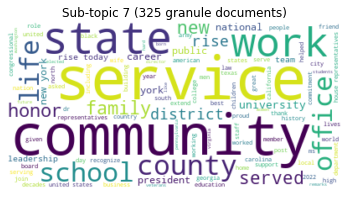

In [28]:
num_max_word_cloud_words = 100
num_topics = len(topic_word_distributions_t6)

names = globals()
for i in range(len(topic_word_distributions_t6)):
    wc = WordCloud(max_words=num_max_word_cloud_words,background_color='white')
    wc.generate_from_frequencies(dict(zip(vocabs_t6, topic_word_distributions_t6[i])))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Sub-topic %d' % i + ' (%d granule documents)' % topics_hist_t6[i][1])
    with BytesIO() as buffer:
        #plot_wordcloud(i).save(buffer, 'png')
        plt.savefig(buffer, format = "png")
        names['img%s' % i] = base64.b64encode(buffer.getvalue()).decode()

# DEPLOYMENT

## Placeholder updates

In [129]:
first_day = summary_df['dateIssued'][0]
last_day = summary_df['dateIssued'][len(summary_df)-1]

perplexity = 80
pca_clusters = 'three'
issue_topic = 'topic 6'

## App layout

In [32]:
app = dash.Dash(external_stylesheets=[dbc.themes.FLATLY])

In [204]:
app.layout = html.Div([
    html.Div([
        html.Div([
            html.H1('Congressional Records Tracking Dashboard',style={'fontSize':36,'color':'white','textAlign': 'center',"font-weight": "bold",'margin-left': '20px'}),
        ],className = 'navbar navbar-expand-lg navbar-dark bg-primary'),
        html.P(['This dashboard helps to show emerging political topics by using unsupervised learning methods. Findings listed below are based on CREC data requested from GovInfo API through ',
               last_day,' to ',first_day,'.'],
               style = {'fontSize':'20px','margin-left': '20px','margin-top': '20px','margin-bottom': '20px',}),
    ],style={'float':'left', 'display': 'inline-block'}),
    
    html.Div([
        html.Div([
            html.H2("Active Level Distribution",className = 'text-primary',style={'fontSize':24,"font-weight": "bold"})
        ],className='card-header'),
        html.Div(
            children=[       
                dcc.Graph(
                    figure={
                        "data": [
                            {
                                "x": num_granules_df['dateIssued'],
                                "y": num_granules_df['granulesCount'],
                                "type": "bar",'name':'Number of record granules',
                            },
                            {
                                "x": num_pages_df['dateIssued'],
                                "y": num_pages_df['pages'],
                                "type": "bar",'name':'Number of record pages'
                            },
                        ],
                        "layout":{"colorway": ["#5F9EA0","#A9A9A9"]}
                    },
                ),
               # html.H5('Different indexes help to identify the active level of congress in recent days'),
            ],className='card-body'
        ),
    ],className = "card border-light mb-3",
       style={'width': '93%', 
                'float':'left',
                'margin-left': '50px',
                'display': 'inline-block',}),

    
    html.Div([
        html.Div([
            html.H2("LDA Topic Modelling",className='text-primary',style={'fontSize':24,"font-weight": "bold"}),
        ],className='card-header'),
        html.Div([
            html.H3("Topic clusters of the Congressal records based on topic modelling using Latent Dirichlet Allocation.",
                        className = 'card-title',style={'fontSize':20}),
            html.Div([
                #html.Label("Number of Granule Documents in Each Topic",className = 'card-text', style={'font': {'size':'40px'}}),
                dcc.Graph(
                    figure={
                        "data": [
                            {
                                "x": get_hist(topics_hist)[0],
                                "y": get_hist(topics_hist)[1],
                                "type": "bar",
                            },
                        ],
                        "layout":{"title": {'text':'Number of Granule Documents among Topics','font': {'size': 16}},
                                 "colorway":["#4682B4"]},
                    },
                ),
            ], style={'textAlign': 'center'}),
            html.Div([
                html.Label("Top Granule Document among Topics",className = 'card-text', style={'margin-bottom': '20px','font': {'size':'40px'}}),
                html.Div([
                    dash_table.DataTable(topic_docs_table.to_dict('records'),
                                         [{"name": i, "id": i} for i in topic_docs_table.columns], 
                                            #style_data={'whiteSpace': 'normal','height': 'auto',},
                                             style_cell={
                                                 'font_size': '12px',
                                                 'font_family': 'arial',
                                                 'textAlign': 'left',
                                                 'overflow': 'hidden',
                                                 'textOverflow': 'ellipsis',
                                                 'maxWidth': 5
                                             },
                                             style_header={
                                                 'font_size': '14px',
                                                 'font_family': 'arial',
                                                 'textAlign': 'center',
                                                 'fontWeight': 'bold',
                                             },
                                             tooltip_data=[
                                                {
                                                    column: {'value': str(value), 'type': 'markdown'}
                                                    for column, value in row.items()
                                                } for row in topic_docs_table.to_dict('records')
                                            ],
                                            tooltip_duration=None,
                                            id='tbl'),
                ],style={'color': '#696969'}),
            ], style={'textAlign': 'center'}),
        ],className='card-body')
    ],className = "card border-light mb-3",
       style={'width': '93%', 
                'float':'left',
                'margin-left': '50px',
                'display': 'inline-block',}),                
      
    
    html.Div([
        html.Div([
            html.H2("T-SNE Visualization",className='text-primary',style={'fontSize':24,"font-weight": "bold"}),
        ],className='card-header'),
        html.Div(
            children=[
                html.H3(["Visualize topic clusters using t-Distributed Stochastic Neighbor Embedding to reduce dimensions. This t-SNE graph uses a perplexity of ",
                        perplexity],
                        className='card-title',style={'fontSize':20}),            
                dcc.Graph(
                    id='tsne-chart',figure = tsne_fig
                ),
                html.H3("Different topic clusters are generally separable in the t-SNE graph, validating the performance of topic modelling.",
                        className='text-muted',style={'fontSize':20}),                  
            ],className='card-body'
        )
    ],className = "card border-light mb-3",
       style={'width': '93%', 
                'float':'left',
                'margin-left': '50px',
                'display': 'inline-block',}),    
    
    
    html.Div([
        html.Div([
            html.H2("PCA Visualization",className='text-primary',style={'fontSize':24,"font-weight": "bold"}),
        ],className='card-header'),
        html.Div(
            children=[
                html.H3("Visualize topic clusters using Principal Component Analysis to reduce dimensions.Different from t-SNE visualization, distances in PCA plot implies the similarity between points (represent granule documents in this context).",
                        className='card-title',style={'fontSize':20}),
                html.Div(
                    children=[
                    dcc.Graph(
                        id='pca-chart',figure = pca_fig
                    ),
                    dcc.Graph(
                        id='pca-class-chart',figure = pca_class_fig
                    ),  
                    ]),
                html.H3(["PCA visualization suggests there're basically ",pca_clusters," groups in collected congressional records.\n",
                         "The primary cluster (topic) simultaneously covered by the Senate, House and Extension documents by the House is ",
                         issue_topic,". Considering the nature of extension documents, which is only used only by representative to add extro information, ",
                         issue_topic," is therefore considered as a topic covering most political discussions, while all other topics are more administrative or routine oriented.\n",
                        "The following part will explore specific political issues discussed in ",issue_topic,
                         " by applying the LDA modelling exclusively on granule documents of ",issue_topic, "."],
                        className='text-muted',style={'fontSize':18,'whiteSpace': 'pre-wrap','margin-bottom': '20px'}),
            ],className='card-body'
        ),
    ],className = "card border-light mb-3",
       style={'width': '93%', 
                'float':'left',
                'margin-left': '50px',
                'display': 'inline-block',}),    
    
    
    html.Div([
        html.Div([
            html.H2("Sub-topic Explorations",className='text-primary',style={'fontSize':24,"font-weight": "bold"}),
        ],className='card-header'),
        html.Div(
            children=[
                html.H3(["Word coulds of top words in each sub-topic of ",issue_topic," using bilinear interpolation method."],
                        className='card-title',style={'fontSize':20}),            
                html.Div([
                    html.Img(src="data:image/png;base64," + img0, style={'width':'100%'}),
                ],style={'width': '33.3%','textAlign': 'center','float':'left', 'display': 'inline-block'}),
                html.Div([
                    html.Img(src="data:image/png;base64," + img1, style={'width':'100%'}),
                ],style={'width': '33.3%','textAlign': 'center','float':'left', 'display': 'inline-block'}),
                html.Div([
                    html.Img(src="data:image/png;base64," + img2, style={'width':'100%'}),
                ],style={'width': '33.3%','textAlign': 'center','float':'left', 'display': 'inline-block'}),
                html.Div([
                    html.Img(src="data:image/png;base64," + img3, style={'width':'100%'}),
                ],style={'width': '33.3%','textAlign': 'center','float':'left', 'display': 'inline-block'}),
                html.Div([
                    html.Img(src="data:image/png;base64," + img4, style={'width':'100%'}),
                ],style={'width': '33.3%','textAlign': 'center','float':'left', 'display': 'inline-block'}),
                html.Div([
                    html.Img(src="data:image/png;base64," + img5, style={'width':'100%'}),
                ],style={'width': '33.3%','textAlign': 'center','float':'left', 'display': 'inline-block'}),
                html.Div([
                    html.Img(src="data:image/png;base64," + img6, style={'width':'100%'}),
                ],style={'width': '33.3%','textAlign': 'center','float':'left', 'display': 'inline-block'}),
                html.Div([
                    html.Img(src="data:image/png;base64," + img7, style={'width':'100%'}),
                ],style={'width': '33.3%','textAlign': 'center','float':'left', 'display': 'inline-block'}),
            ],className='card-body'
        )
    ],className = "card border-light mb-3",
       style={'width': '93%', 
                'float':'left',
                'margin-left': '50px',
                'display': 'inline-block',}),    

])
    

In [ ]:
if __name__ == '__main__':
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [22/Jan/2023 19:47:26] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [22/Jan/2023 19:47:26] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [22/Jan/2023 19:47:26] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [22/Jan/2023 19:47:26] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [22/Jan/2023 19:47:26] "GET /_dash-component-suites/dash/dash_table/async-highlight.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Jan/2023 19:47:26] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [22/Jan/2023 19:47:27] "GET /_dash-component-suites/dash/dash_table/async-table.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Jan/2023 19:57:37] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [22/Jan/2023 19:57:37] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [22/Jan/2023 19:57:37] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [22/Jan/2023 19:57:37] "GET /_dash-component-suites/dash/dcc/